In [3]:
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv

torch.manual_seed(1)

In [4]:
filepath = '/Users/js/Desktop/datasets/sp500/CMS.csv'

values = []

with open(filepath, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        values.append(row[4])

values = [float(j) for j in values]

values = torch.tensor(values)
values = values / max(values)

x = values[:-1].unsqueeze(1)
y = values[1:].unsqueeze(1)

batch_size = 8
chunks = len(x) // batch_size

x = x[:chunks * batch_size]
x = x.reshape(batch_size, -1, 1)

y = y[:chunks * batch_size]
y = y.reshape(batch_size, -1, 1)

times = torch.arange(1, chunks * batch_size + 1)
times = times[:batch_size * chunks]

print(times.shape)
print(x.shape)
print(y.shape)

torch.Size([1256])
torch.Size([8, 157, 1])
torch.Size([8, 157, 1])


In [5]:
class lstm(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, batch_size, dropout):
        super(lstm, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, dropout=self.dropout)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x, hidden):
        x = x.reshape(-1, 1)
        x = x[:chunks * batch_size]
        x = x.reshape(batch_size, -1, 1)
        
        x = x.reshape(self.batch_size, -1, self.input_dim)
        out, hidden = self.lstm(x)
        out.reshape(-1, self.hidden_dim)
        out = self.output(out)
        return(out, hidden)

In [6]:
model = lstm(input_dim=1, output_dim=1, hidden_dim=8, num_layers=2, batch_size=batch_size, dropout=0.0)
model

lstm(
  (lstm): LSTM(1, 8, num_layers=2, batch_first=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

In [7]:
hidden = None

In [8]:
loss_fn = nn.MSELoss()
optimizer = optim.Adadelta(model.parameters(), eps=1e-5, rho=0.95, lr=1e-1)
#optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

0.014729775488376617


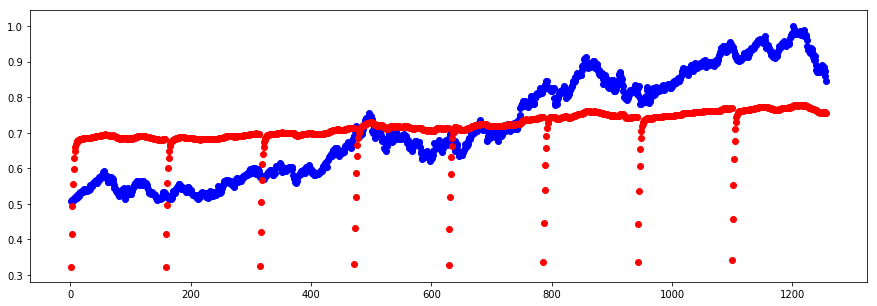

KeyboardInterrupt: 

In [9]:
epochs = 2000
show_every = 500

model.train()
for e in range(epochs):
    model.zero_grad()
    prediction, hidden = model(x, hidden)
    loss = loss_fn(prediction, y)
    loss.backward()
    optimizer.step()
    if (e+1) % show_every == 0:
        print(loss.item())
        plt.figure(figsize=(15, 5))
        prediction = prediction.reshape(-1, 1)
        prediction = prediction.detach().numpy()
        plt.scatter(times, y.reshape(-1, 1), color='b')
        plt.scatter(times, prediction, color='r')
        plt.show()

0.0003895300906151533


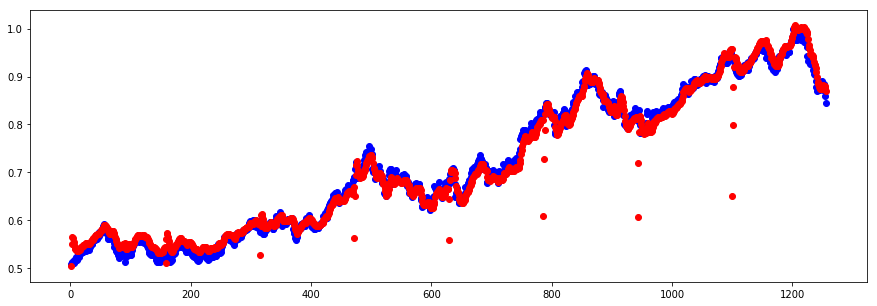

In [117]:
model.eval()
prediction, hidden = model(x, hidden)
loss = loss_fn(prediction, y)
print(loss.item())
plt.figure(figsize=(15, 5))
prediction = prediction.reshape(-1, 1)
prediction = prediction.detach().numpy()
plt.scatter(times, y.squeeze(0), color='b')
plt.scatter(times, prediction, color='r')
plt.show()

torch.Size([8, 157, 1])
torch.Size([9, 157, 1])


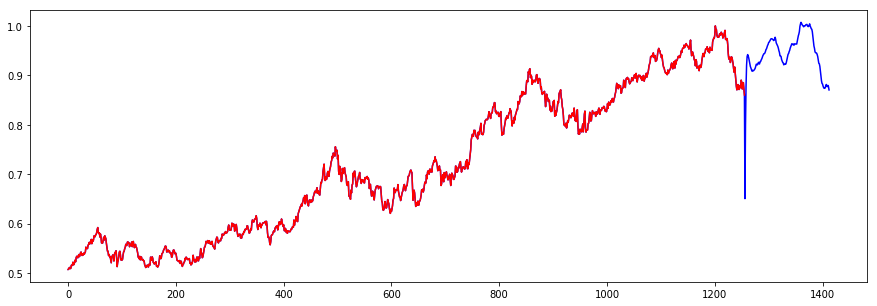

In [118]:
x2 = x
for i in range(1):
    prediction, hidden = model(x2, hidden)
    x2 = torch.cat((x2, prediction[-1].unsqueeze(0)), dim=0)

print(x.shape)
print(x2.shape)

plt.figure(figsize=(15, 5))
x3 = x.detach().numpy().reshape(-1)
x2 = x2.detach().numpy().reshape(-1)

plt.plot(x2, color='b')
plt.plot(x3, color='r')

plt.show()